# Детекция аномалий в сетевом трафике

Было принято решение использовать ts подход, т.к он наиболее подходит в данном случае для оценки. Верхнеуровненвое описание пайплайна примерно такое:

- PCAP -> оконные признаки
- TS-EDA, проверка стационарности, ACF/PACF, STL
- детекция аномалий через прогноз и остатки: ETS, ARIMA, SARIMA, SARIMAX
- детекция аномалий через ML на оконных признаках: IsolationForest


In [164]:
from __future__ import annotations

import pickle
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in dir() else Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from core.time_series.pcap_converter import PCAPConverter
from core.time_series.ts_models import TimeSeriesAnomalyDetector

## Конфигурация

Работаем с нормальным и аномальным трафиков. Обучать можем только на "нормальном". Далее смотрим отклонение от baseline

- `normal_pcaps` используются для обучения(baseline нормального трафика)
- `test_pcaps` проверяются моделями и содержат как нормальные, так и аномальные файлы


In [ ]:
DATA_ROOT = Path("~/HSE/hse_ai_traffic_anomalies/data/iot23").expanduser()

TRAIN_PCAP = DATA_ROOT / "normal/2018-09-14-13-40-25-Philips-Hue-Bridge.pcap"


TEST_PCAPS = [
    # (DATA_ROOT / "test/normal/2018-09-21-capture.pcap", "normal"),
    (DATA_ROOT / "normal/2018-10-25-14-06-32-192.168.1.132.pcap", "normal"),
    (DATA_ROOT / "test/anomaly/2018-05-09-192.168.100.103.pcap", "anomaly"),
]

WINDOW_SIZE = 10 # в секундах
# по размеру окна были различные эксперименты, но в итоге остановился на 10 секундах
TARGET_COL = "packet_count"

CACHE_DIR = Path("cache_ts")
CACHE_DIR.mkdir(exist_ok=True)

In [ ]:
converter = PCAPConverter(window_size=WINDOW_SIZE) # класс который отвечает за 

# train - один файл
train_cache = CACHE_DIR / f"{TRAIN_PCAP.stem}_normal_w{WINDOW_SIZE}.pkl"
if train_cache.exists():
    print(f"cache: {train_cache.name}")
    with train_cache.open("rb") as f:
        train_df = pickle.load(f)
else:
    train_df = converter.convert(str(TRAIN_PCAP), label="normal")
    if not train_df.empty:
        train_df["source"] = TRAIN_PCAP.name
        with train_cache.open("wb") as f:
            pickle.dump(train_df, f)

# test - несколько файлов, но анализируем отдельно
test_dfs = {}
for pcap, label in TEST_PCAPS:
    cache = CACHE_DIR / f"{pcap.stem}_{label}_w{WINDOW_SIZE}.pkl"
    if cache.exists():
        print(f"cache: {cache.name}")
        with cache.open("rb") as f:
            df = pickle.load(f)
    else:
        df = converter.convert(str(pcap), label=label)
        if not df.empty:
            df["source"] = pcap.name
            with cache.open("wb") as f:
                pickle.dump(df, f)
    test_dfs[pcap.stem] = (df, label)

print(f"train: {train_df.shape}")
for name, (df, label) in test_dfs.items():
    print(f"test {name} ({label}): {df.shape}")

processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2018-09-14-13-40-25-Philips-Hue-Bridge.pcap
  packets: 8573, errors: 0
  windows: 235
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2018-10-25-14-06-32-192.168.1.132.pcap
  packets: 21664, errors: 0
  windows: 7885
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/test/anomaly/2018-05-09-192.168.100.103.pcap
  packets: 1686291, errors: 0
  windows: 40286
train: (235, 26)
test 2018-10-25-14-06-32-192.168.1.132 (normal): (7885, 26)
test 2018-05-09-192.168.100.103 (anomaly): (40286, 26)


In [167]:
# Cell - EDA для train

if train_df.empty:
    raise RuntimeError("empty train data")

train_ts = train_df.set_index("timestamp")[TARGET_COL].astype(float)

# убираем нулевые окна в начале/конце если есть
train_ts = train_ts[train_ts > 0]

print(f"train length: {len(train_ts)}")
print(f"time range: {train_ts.index.min()} - {train_ts.index.max()}")
print(f"duration: {train_ts.index.max() - train_ts.index.min()}")

# базовая статистика
print(f"\nstats:\n{train_ts.describe()}")

train length: 200
time range: 2018-09-14 11:40:27.140657902 - 2018-09-14 12:19:27.140657902
duration: 0 days 00:39:00

stats:
count     200.000000
mean       42.865000
std       101.428871
min         1.000000
25%         5.000000
50%         9.500000
75%        36.750000
max      1066.000000
Name: packet_count, dtype: float64


In [168]:
# Cell - Сравнительный анализ всех PCAP файлов

import glob
from collections import defaultdict

# Сканируем все PCAP файлы
pcap_dirs = {
    "normal": DATA_ROOT / "normal",
    "anomaly": DATA_ROOT / "test/anomaly",
}

all_pcaps = []
for label, dir_path in pcap_dirs.items():
    if dir_path.exists():
        for pcap in dir_path.glob("*.pcap"):
            all_pcaps.append((pcap, label))

print(f"Найдено PCAP файлов: {len(all_pcaps)}")
for pcap, label in all_pcaps:
    size_mb = pcap.stat().st_size / 1024 / 1024
    print(f"  [{label}] {pcap.name} ({size_mb:.1f} MB)")

Найдено PCAP файлов: 13
  [normal] 2019-07-04-16-41-10-192.168.1.158.pcap (16.4 MB)
  [normal] 2018-10-25-14-06-32-192.168.1.132.pcap (4.4 MB)
  [normal] 2017-05-01_normal.pcap (725.1 MB)
  [normal] 2019-07-03-16-41-09-192.168.1.158.pcap (31.6 MB)
  [normal] 2017-05-02_normal.pcap (822.3 MB)
  [normal] 2019-07-03-15-15-47-first_start_somfy_gateway.pcap (2.0 MB)
  [normal] 2018-09-14-13-40-25-Philips-Hue-Bridge.pcap (2.3 MB)
  [normal] 2017-07-03_capture-win2.pcap (0.5 MB)
  [anomaly] 2017-07-13_capture-win2.pcap (6.8 MB)
  [anomaly] 2018-07-25-10-53-16-192.168.100.111.pcap (471.6 MB)
  [anomaly] 2018-12-21-15-50-14-192.168.1.195.pcap (120.5 MB)
  [anomaly] 2018-05-09-192.168.100.103.pcap (139.2 MB)
  [anomaly] 2018-12-21-13-36-41-192.168.1.198.pcap (991.4 MB)


In [169]:
# Cell - Загрузка статистик всех файлов

def get_pcap_stats(pcap_path: Path, label: str, window_size: int = 10) -> dict | None:
    """Быстрая статистика PCAP без полной конвертации"""
    cache = CACHE_DIR / f"{pcap_path.stem}_{label}_w{window_size}.pkl"
    
    if cache.exists():
        with cache.open("rb") as f:
            df = pickle.load(f)
    else:
        conv = PCAPConverter(window_size=window_size)
        df = conv.convert(str(pcap_path), label=label)
        if df.empty:
            return None
        with cache.open("wb") as f:
            pickle.dump(df, f)
    
    if df.empty:
        return None
    
    ts = df.set_index("timestamp")
    duration = (ts.index.max() - ts.index.min()).total_seconds()
    
    stats = {
        "name": pcap_path.stem[:40],  # обрезаем длинные имена
        "label": label,
        "windows": len(df),
        "duration_min": round(duration / 60, 1),
        "packets_total": int(df["packet_count"].sum()),
        "packets_mean": round(df["packet_count"].mean(), 1),
        "packets_std": round(df["packet_count"].std(), 1),
        "packets_max": int(df["packet_count"].max()),
        "bytes_mean": round(df["byte_count"].mean(), 0),
        "unique_ips_mean": round(df["unique_src_ips"].mean() + df["unique_dst_ips"].mean(), 1),
        "tcp_ratio_mean": round(df["tcp_ratio"].mean(), 2) if "tcp_ratio" in df.columns else 0,
        "entropy_dst_port_mean": round(df["entropy_dst_port"].mean(), 2) if "entropy_dst_port" in df.columns else 0,
    }
    
    # коэффициент вариации - мера "стабильности" трафика
    if stats["packets_mean"] > 0:
        stats["packets_cv"] = round(stats["packets_std"] / stats["packets_mean"], 2)
    else:
        stats["packets_cv"] = 0
    
    return stats


# Собираем статистики
print("Загрузка статистик(может занять время для новых файлов)")
all_stats = []
for pcap, label in all_pcaps:
    try:
        stats = get_pcap_stats(pcap, label, WINDOW_SIZE)
        if stats:
            all_stats.append(stats)
            print(f"{pcap.name}")
    except Exception as e:
        print(f"{pcap.name}: {e}")

stats_df = pd.DataFrame(all_stats)
print(f"Загружено: {len(stats_df)} файлов")

Загрузка статистик (может занять время для новых файлов)...

processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2019-07-04-16-41-10-192.168.1.158.pcap
  packets: 62851, errors: 0
  windows: 4434
2019-07-04-16-41-10-192.168.1.158.pcap
2018-10-25-14-06-32-192.168.1.132.pcap
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2017-05-01_normal.pcap
  packets: 1240259, errors: 0
  windows: 1353
2017-05-01_normal.pcap
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2019-07-03-16-41-09-192.168.1.158.pcap
  packets: 119638, errors: 0
  windows: 8640
2019-07-03-16-41-09-192.168.1.158.pcap
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2017-05-02_normal.pcap
  packets: 1601294, errors: 0
  windows: 1428
2017-05-02_normal.pcap
processing /home/oppy/HSE/hse_ai_traffic_anomalies/data/iot23/normal/2019-07-03-15-15-47-first_start_somfy_gateway.pcap
  packets: 8276, errors: 0
  windows: 509
2019-07-03-15-15-47-first_start_s

In [170]:
# Cell - Таблица сравнения

display(stats_df.sort_values(["label", "packets_mean"], ascending=[True, False]))

,name,label,windows,duration_min,packets_total,packets_mean,packets_std,packets_max,bytes_mean,unique_ips_mean,tcp_ratio_mean,entropy_dst_port_mean,packets_cv
12,2018-12-21-13-36-41-192.168.1.198,anomaly,8640,1439.8,13670225,1582.2,67.4,1798,95002.0,1579.8,1.00,0.03,0.04
9,2018-07-25-10-53-16-192.168.100.111,anomaly,8637,1439.3,6437837,745.4,396.8,1434,45334.0,743.9,0.80,0.89,0.53
8,2017-07-13_capture-win2,anomaly,97,16.0,19449,200.5,687.1,6718,70156.0,120.2,0.42,0.34,3.43
11,2018-05-09-192.168.100.103,anomaly,40286,6714.2,1686291,41.9,25.3,1256,2953.0,25.0,0.69,3.07,0.60
10,2018-12-21-15-50-14-192.168.1.195,anomaly,8640,1439.8,233865,27.1,575.7,22998,14187.0,2.0,0.41,0.36,21.24
4,2017-05-02_normal,normal,1428,237.8,1601294,1121.4,722.2,6023,585885.0,116.7,0.92,4.39,0.64
2,2017-05-01_normal,normal,1353,225.3,1240259,916.7,817.2,9127,547290.0,82.0,0.91,4.06,0.89
7,2017-07-03_capture-win2,normal,15,2.3,949,63.3,150.2,557,32743.0,4.3,0.33,0.91,2.37
6,2018-09-14-13-40-25-Philips-Hue-Bridge,normal,235,39.0,8573,36.5,94.8,1066,9754.0,8.1,0.25,1.43,2.60
5,2019-07-03-15-15-47-first_start_somfy_ga,normal,509,84.7,8276,16.3,11.6,173,3854.0,5.0,0.69,1.06,0.71


Загружено временных рядов: 13


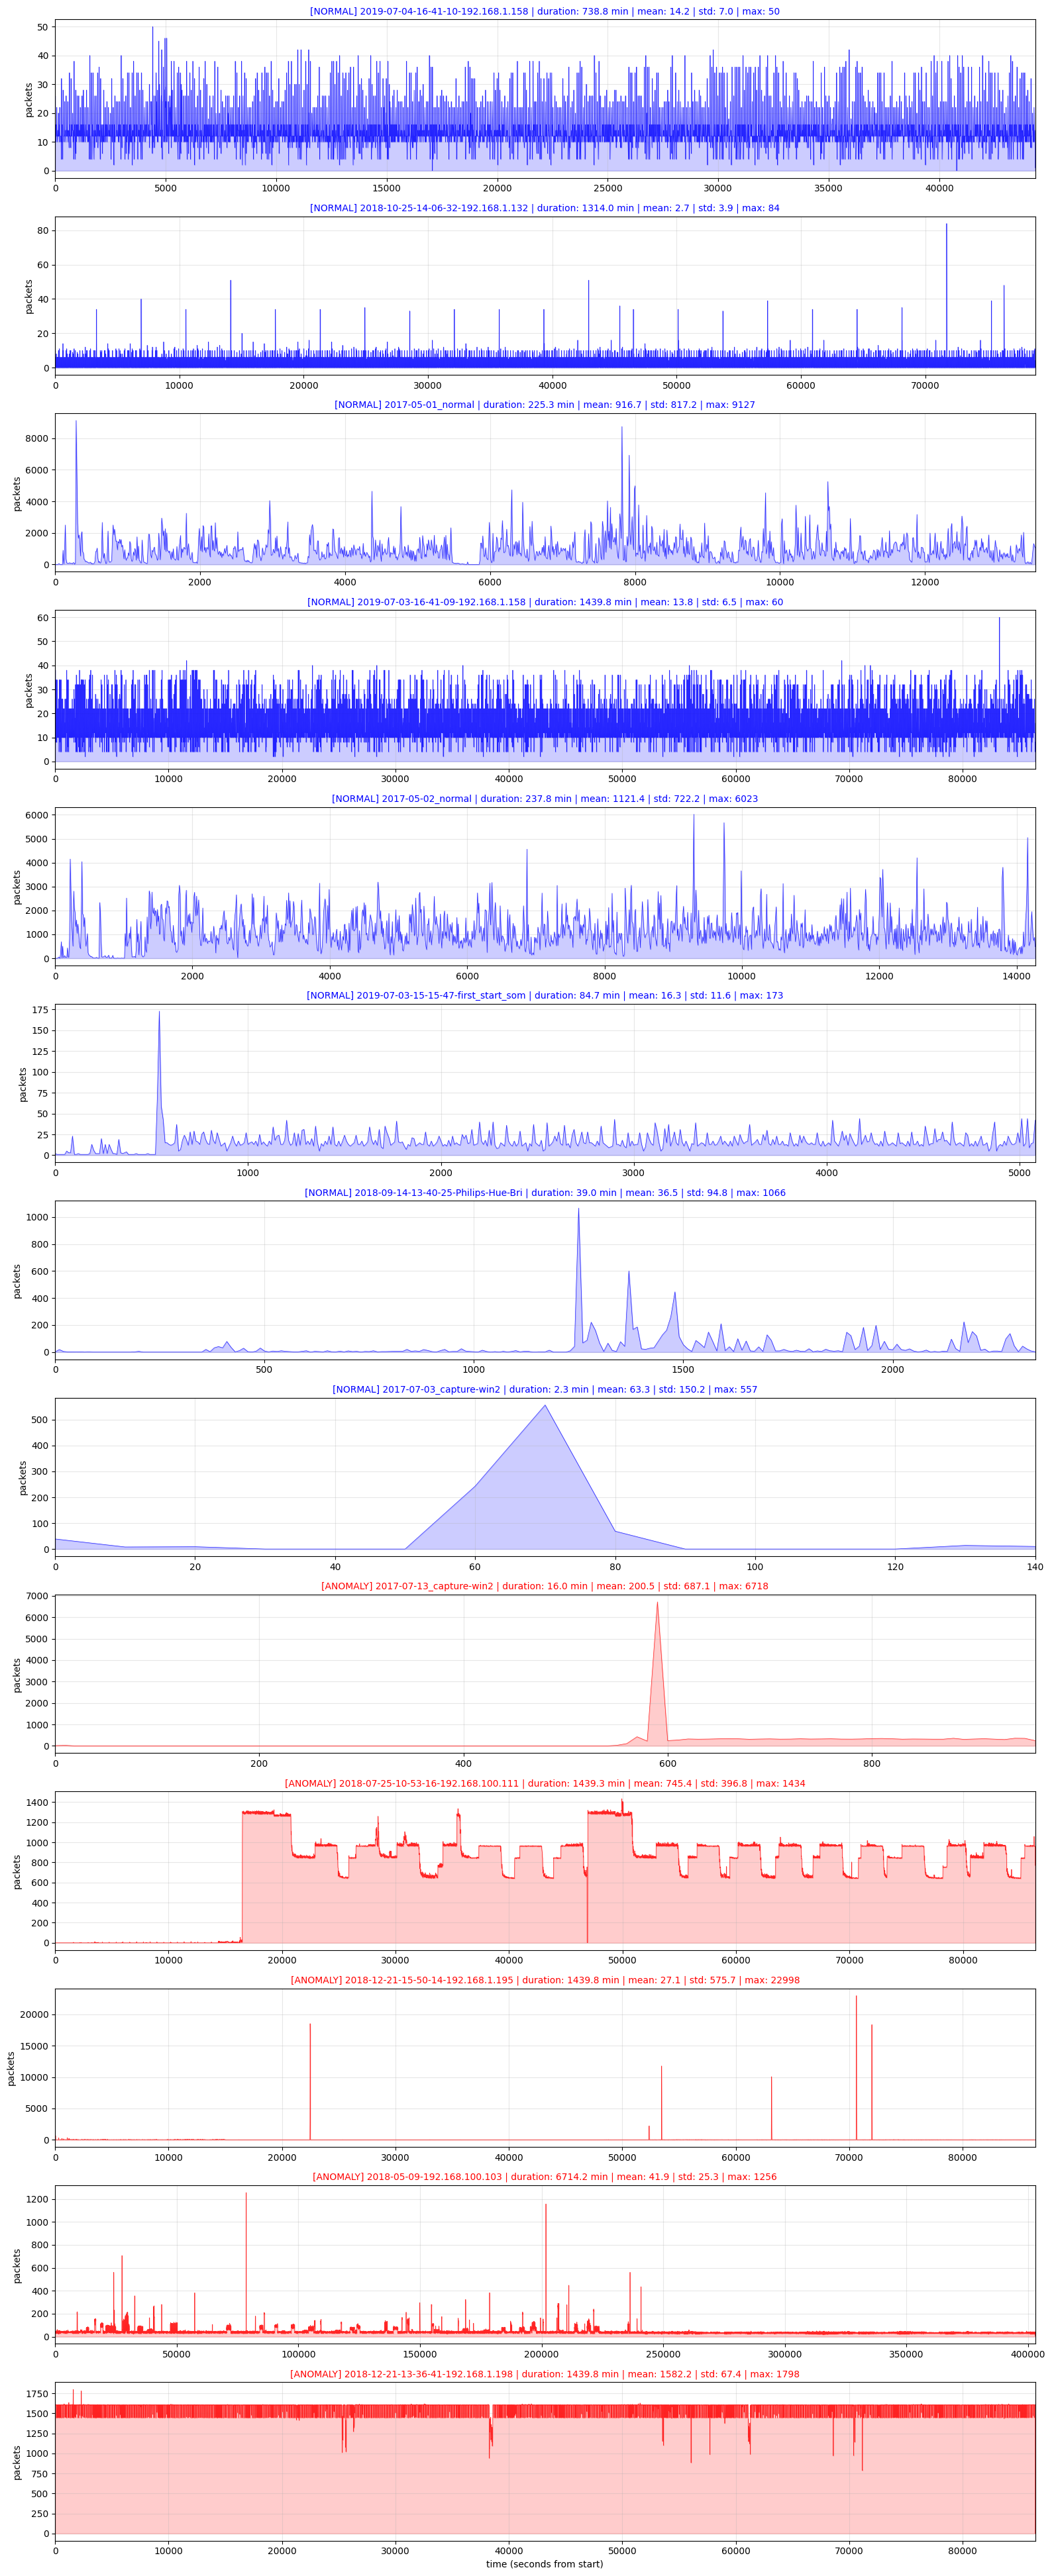

In [171]:
# Cell - Временные ряды всех PCAP файлов

# Загружаем данные для всех файлов
all_ts_data = {}

for pcap, label in all_pcaps:
    cache = CACHE_DIR / f"{pcap.stem}_{label}_w{WINDOW_SIZE}.pkl"
    if cache.exists():
        with cache.open("rb") as f:
            df = pickle.load(f)
        if not df.empty:
            ts = df.set_index("timestamp")[TARGET_COL].astype(float)
            all_ts_data[pcap.stem[:35]] = {"ts": ts, "label": label, "df": df}

print(f"Загружено временных рядов: {len(all_ts_data)}")

# Разделяем по label
normal_ts = {k: v for k, v in all_ts_data.items() if v["label"] == "normal"}
anomaly_ts = {k: v for k, v in all_ts_data.items() if v["label"] == "anomaly"}

# Визуализация
n_normal = len(normal_ts)
n_anomaly = len(anomaly_ts)
n_total = n_normal + n_anomaly

fig, axes = plt.subplots(n_total, 1, figsize=(16, 3 * n_total))
if n_total == 1:
    axes = [axes]

colors = {"normal": "blue", "anomaly": "red"}

idx = 0
# Сначала normal
for name, data in normal_ts.items():
    ax = axes[idx]
    ts = data["ts"]
    
    # Нормализуем время к началу записи для сравнения
    time_seconds = (ts.index - ts.index.min()).total_seconds()
    
    ax.plot(time_seconds, ts.values, color=colors["normal"], alpha=0.8, linewidth=0.5)
    ax.fill_between(time_seconds, 0, ts.values, color=colors["normal"], alpha=0.2)
    
    # Статистики
    duration_min = time_seconds.max() / 60
    ax.set_title(f"[NORMAL] {name} | duration: {duration_min:.1f} min | "
                 f"mean: {ts.mean():.1f} | std: {ts.std():.1f} | max: {ts.max():.0f}",
                 fontsize=10, color="blue")
    ax.set_ylabel("packets")
    ax.set_xlim(0, time_seconds.max())
    ax.grid(True, alpha=0.3)
    idx += 1

# Потом anomaly
for name, data in anomaly_ts.items():
    ax = axes[idx]
    ts = data["ts"]
    
    time_seconds = (ts.index - ts.index.min()).total_seconds()
    
    ax.plot(time_seconds, ts.values, color=colors["anomaly"], alpha=0.8, linewidth=0.5)
    ax.fill_between(time_seconds, 0, ts.values, color=colors["anomaly"], alpha=0.2)
    
    duration_min = time_seconds.max() / 60
    ax.set_title(f"[ANOMALY] {name} | duration: {duration_min:.1f} min | "
                 f"mean: {ts.mean():.1f} | std: {ts.std():.1f} | max: {ts.max():.0f}",
                 fontsize=10, color="red")
    ax.set_ylabel("packets")
    ax.set_xlim(0, time_seconds.max())
    ax.grid(True, alpha=0.3)
    idx += 1

axes[-1].set_xlabel("time (seconds from start)")
plt.tight_layout()
plt.show()

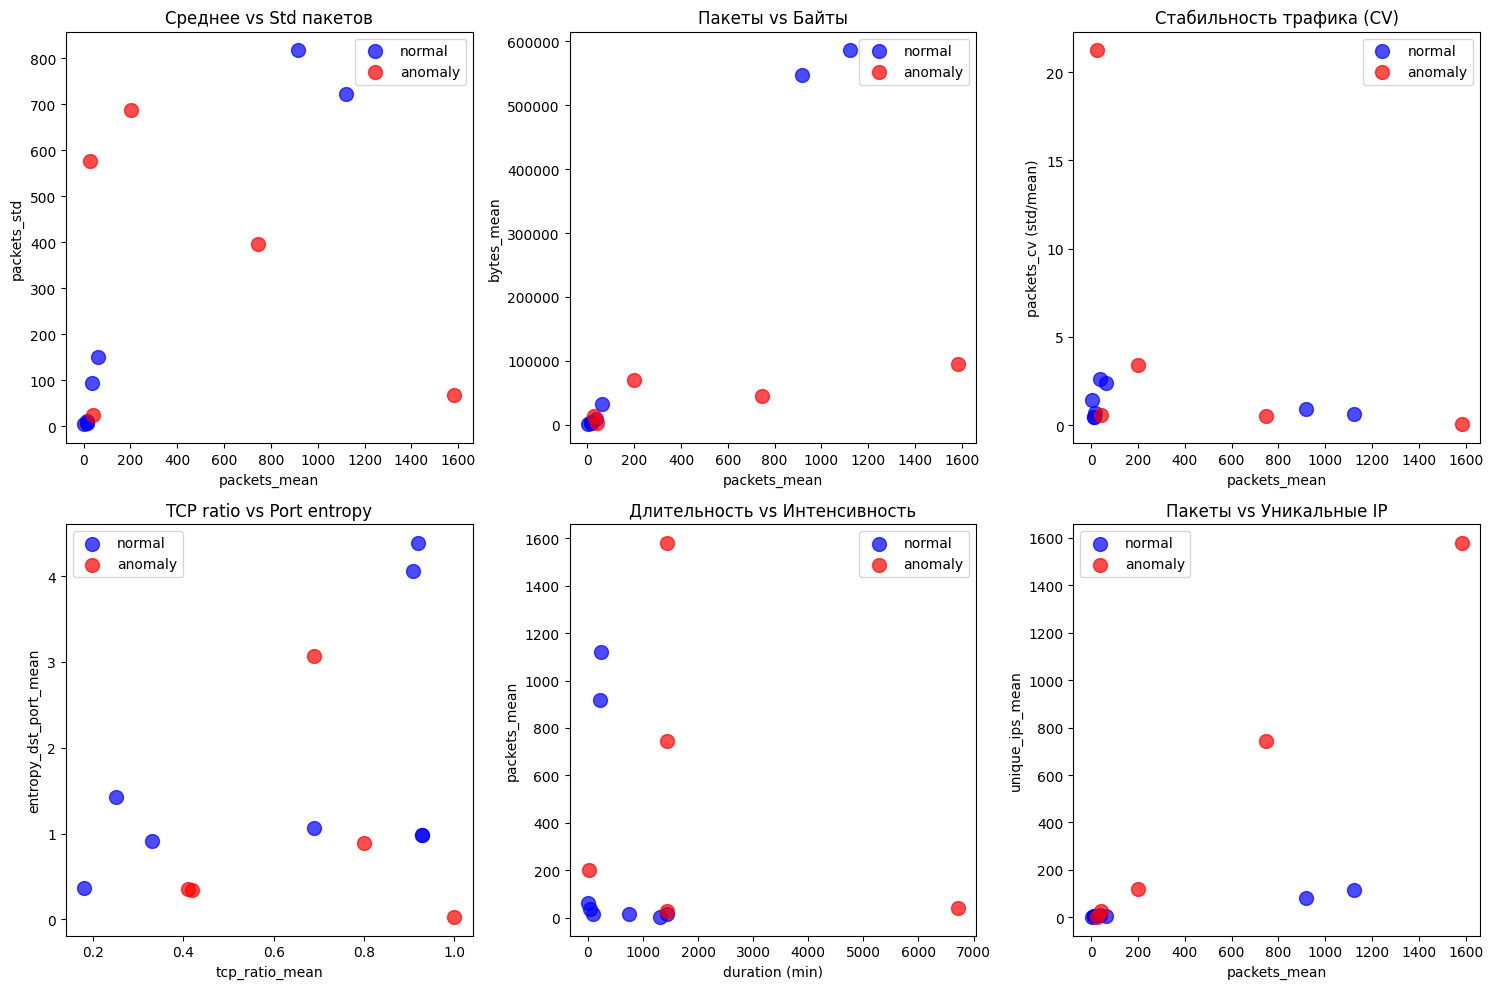

In [172]:
# Cell - Визуальное сравнение характеристик

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Цвета по label
colors = {"normal": "blue", "anomaly": "red"}
color_list = [colors[l] for l in stats_df["label"]]

# 1. packets_mean vs packets_std
ax = axes[0, 0]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["packets_mean"], stats_df[mask]["packets_std"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("packets_mean")
ax.set_ylabel("packets_std")
ax.set_title("Среднее vs Std пакетов")
ax.legend()

# 2. packets_mean vs bytes_mean
ax = axes[0, 1]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["packets_mean"], stats_df[mask]["bytes_mean"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("packets_mean")
ax.set_ylabel("bytes_mean")
ax.set_title("Пакеты vs Байты")
ax.legend()

# 3. Coefficient of Variation
ax = axes[0, 2]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["packets_mean"], stats_df[mask]["packets_cv"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("packets_mean")
ax.set_ylabel("packets_cv (std/mean)")
ax.set_title("Стабильность трафика (CV)")
ax.legend()

# 4. TCP ratio vs entropy
ax = axes[1, 0]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["tcp_ratio_mean"], stats_df[mask]["entropy_dst_port_mean"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("tcp_ratio_mean")
ax.set_ylabel("entropy_dst_port_mean")
ax.set_title("TCP ratio vs Port entropy")
ax.legend()

# 5. Duration vs packets
ax = axes[1, 1]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["duration_min"], stats_df[mask]["packets_mean"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("duration (min)")
ax.set_ylabel("packets_mean")
ax.set_title("Длительность vs Интенсивность")
ax.legend()

# 6. Unique IPs
ax = axes[1, 2]
for label in ["normal", "anomaly"]:
    mask = stats_df["label"] == label
    ax.scatter(stats_df[mask]["packets_mean"], stats_df[mask]["unique_ips_mean"], 
               c=colors[label], label=label, alpha=0.7, s=100)
ax.set_xlabel("packets_mean")
ax.set_ylabel("unique_ips_mean")
ax.set_title("Пакеты vs Уникальные IP")
ax.legend()

plt.tight_layout()
plt.show()

In [173]:
# Cell - Поиск похожих файлов для train/test

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Признаки для сравнения
compare_cols = ["packets_mean", "packets_std", "packets_cv", "bytes_mean", 
                "unique_ips_mean", "tcp_ratio_mean", "entropy_dst_port_mean"]

# Нормализация
X = stats_df[compare_cols].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Матрица похожести (cosine)
sim_matrix = cosine_similarity(X_scaled)

# Создаём DataFrame с похожестью
sim_df = pd.DataFrame(sim_matrix, 
                      index=stats_df["name"], 
                      columns=stats_df["name"])

print("=== Матрица косинусной похожести ===\n")
print("(1.0 = идентичный характер трафика, 0.0 = совсем разный)\n")

=== Матрица косинусной похожести ===

(1.0 = идентичный характер трафика, 0.0 = совсем разный)



In [174]:
# Cell - Рекомендации по выбору train/test пар

print("=== Рекомендации для train/test пар ===\n")

# Для каждого normal файла находим наиболее похожие anomaly файлы
normal_mask = stats_df["label"] == "normal"
anomaly_mask = stats_df["label"] == "anomaly"

normal_names = stats_df[normal_mask]["name"].tolist()
anomaly_names = stats_df[anomaly_mask]["name"].tolist()

print("Лучшие пары (normal train → anomaly test с похожим характером):\n")

recommendations = []
for n_name in normal_names:
    if n_name not in sim_df.index:
        continue
    
    best_anomaly = None
    best_sim = -1
    
    for a_name in anomaly_names:
        if a_name not in sim_df.columns:
            continue
        sim = sim_df.loc[n_name, a_name]
        if sim > best_sim:
            best_sim = sim
            best_anomaly = a_name
    
    if best_anomaly:
        recommendations.append({
            "train (normal)": n_name,
            "test (anomaly)": best_anomaly,
            "similarity": round(best_sim, 3),
        })

rec_df = pd.DataFrame(recommendations).sort_values("similarity", ascending=False)
display(rec_df)

print("\n" + "="*60)
print("ИНТЕРПРЕТАЦИЯ:")
print("  similarity > 0.9  → очень похожий трафик, хорошая пара")
print("  similarity 0.7-0.9 → умеренно похожий, приемлемо")
print("  similarity < 0.7  → разный характер, модели будут плохо работать")

=== Рекомендации для train/test пар ===

Лучшие пары (normal train → anomaly test с похожим характером):



,train (normal),test (anomaly),similarity
5,2019-07-03-15-15-47-first_start_somfy_ga,2018-05-09-192.168.100.103,0.592
3,2019-07-03-16-41-09-192.168.1.158,2018-05-09-192.168.100.103,0.504
0,2019-07-04-16-41-10-192.168.1.158,2018-05-09-192.168.100.103,0.503
7,2017-07-03_capture-win2,2017-07-13_capture-win2,0.373
6,2018-09-14-13-40-25-Philips-Hue-Bridge,2018-05-09-192.168.100.103,0.362
1,2018-10-25-14-06-32-192.168.1.132,2017-07-13_capture-win2,0.283
4,2017-05-02_normal,2018-07-25-10-53-16-192.168.100.111,0.064
2,2017-05-01_normal,2018-07-25-10-53-16-192.168.100.111,0.046



ИНТЕРПРЕТАЦИЯ:
  similarity > 0.9  → очень похожий трафик, хорошая пара
  similarity 0.7-0.9 → умеренно похожий, приемлемо
  similarity < 0.7  → разный характер, модели будут плохо работать


## TS-EDA

Выбираем таргет (например `packet_count`) и строим базовую диагностику.

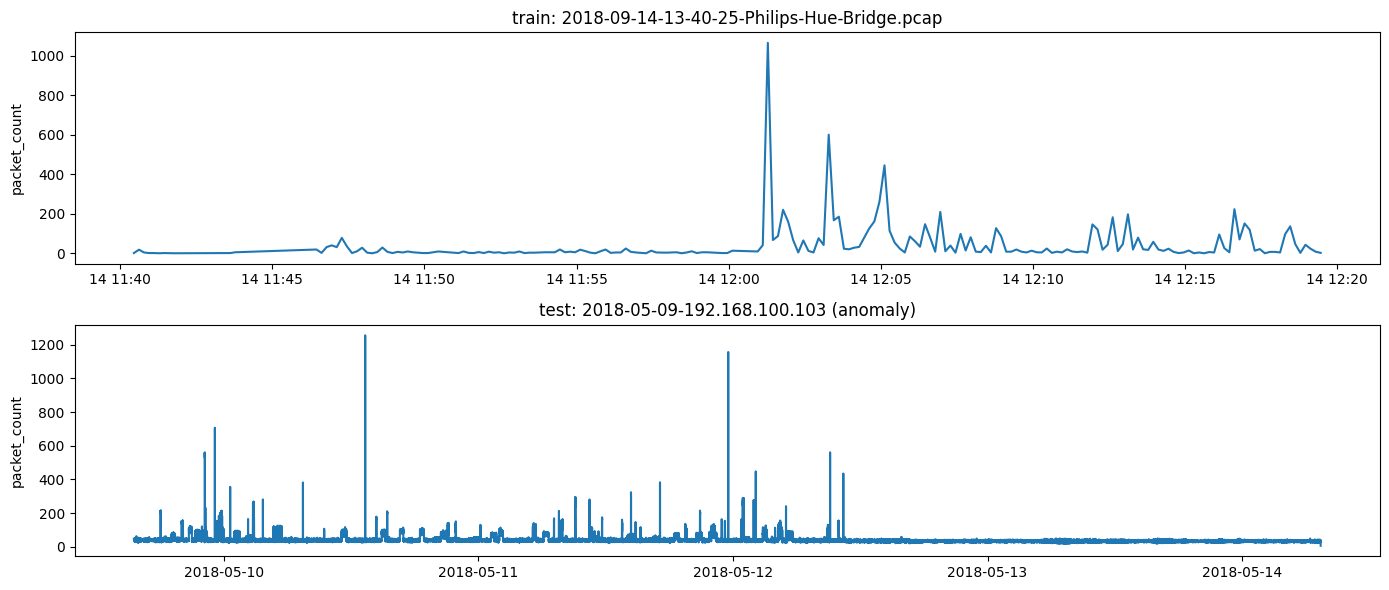

In [175]:
# Cell - Time series plots
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# train
axes[0].plot(train_ts.index, train_ts.values)
axes[0].set_title(f"train: {TRAIN_PCAP.name}")
axes[0].set_ylabel(TARGET_COL)

# один из test файлов для сравнения
test_name = list(test_dfs.keys())[1]
test_df, test_label = test_dfs[test_name]
test_ts = test_df.set_index("timestamp")[TARGET_COL].astype(float)

axes[1].plot(test_ts.index, test_ts.values)
axes[1].set_title(f"test: {test_name} ({test_label})")
axes[1].set_ylabel(TARGET_COL)

plt.tight_layout()
plt.show()

In [176]:
# Cell - Stationarity tests

from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series: pd.Series, name: str):
    series = series.dropna()
    
    # ADF: H0 = есть unit root (нестационарный)
    adf_stat, adf_pval, _, _, adf_crit, _ = adfuller(series, autolag="AIC")
    
    # KPSS: H0 = стационарный
    kpss_stat, kpss_pval, _, kpss_crit = kpss(series, nlags="auto")
    
    print(f"\n{name}:")
    print(f"  ADF:  stat={adf_stat:.4f}, p={adf_pval:.4f} {'stationary' if adf_pval < 0.05 else 'non-stationary'}")
    print(f"  KPSS: stat={kpss_stat:.4f}, p={kpss_pval:.4f} {'tationary' if kpss_pval > 0.05 else 'non-stationary'}")

test_stationarity(train_ts, "train")

for name, (df, label) in test_dfs.items():
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    test_stationarity(ts, f"test/{name}")


train:
  ADF:  stat=-2.0170, p=0.2792 non-stationary
  KPSS: stat=0.4205, p=0.0683 tationary


/tmp/ipykernel_18191/1108830328.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_pval, _, kpss_crit = kpss(series, nlags="auto")



test/2018-10-25-14-06-32-192.168.1.132:
  ADF:  stat=-15.8333, p=0.0000 stationary
  KPSS: stat=0.0677, p=0.1000 tationary

test/2018-05-09-192.168.100.103:
  ADF:  stat=-15.7222, p=0.0000 stationary
  KPSS: stat=8.8142, p=0.0100 non-stationary


/tmp/ipykernel_18191/1108830328.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, _, kpss_crit = kpss(series, nlags="auto")


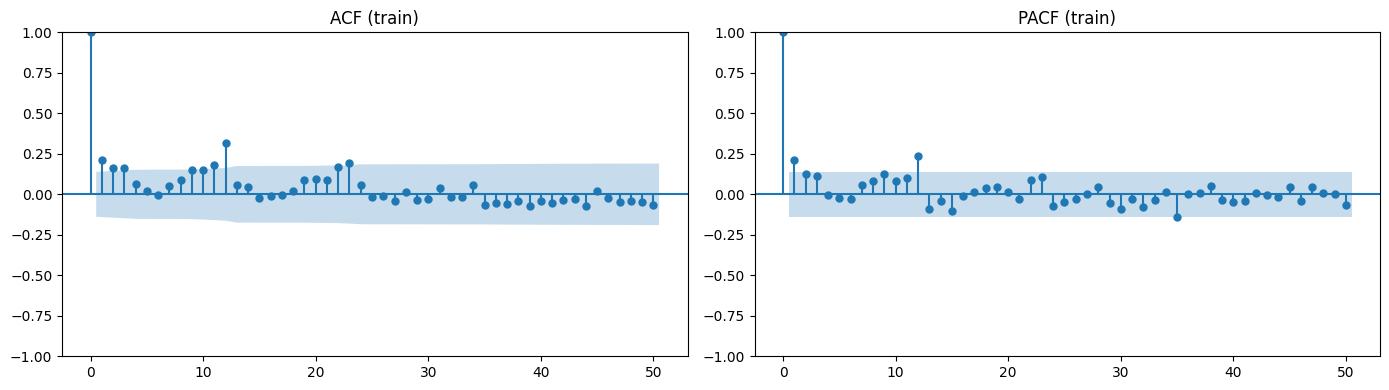


ACF interpretation:
  - Медленное затухание → тренд или нестационарность
  - Периодические пики → сезонность
  - Резкое падение после lag 1 → MA(1) компонент

PACF interpretation:
  - Резкое падение после lag p → AR(p) компонент
  - Lag 1 значимый → AR(1)


In [177]:
# Cell - ACF/PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ограничиваем lags
max_lags = min(100, len(train_ts) // 4)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_ts.dropna(), lags=max_lags, ax=axes[0])
plot_pacf(train_ts.dropna(), lags=max_lags, method="ywm", ax=axes[1])
axes[0].set_title("ACF (train)")
axes[1].set_title("PACF (train)")
plt.tight_layout()
plt.show()

# интерпретация
print("\nACF interpretation:")
print("  - Медленное затухание → тренд или нестационарность")
print("  - Периодические пики → сезонность")
print("  - Резкое падение после lag 1 → MA(1) компонент")

print("\nPACF interpretation:")
print("  - Резкое падение после lag p → AR(p) компонент")
print("  - Lag 1 значимый → AR(1)")

STL period: 60 windows (600 seconds)


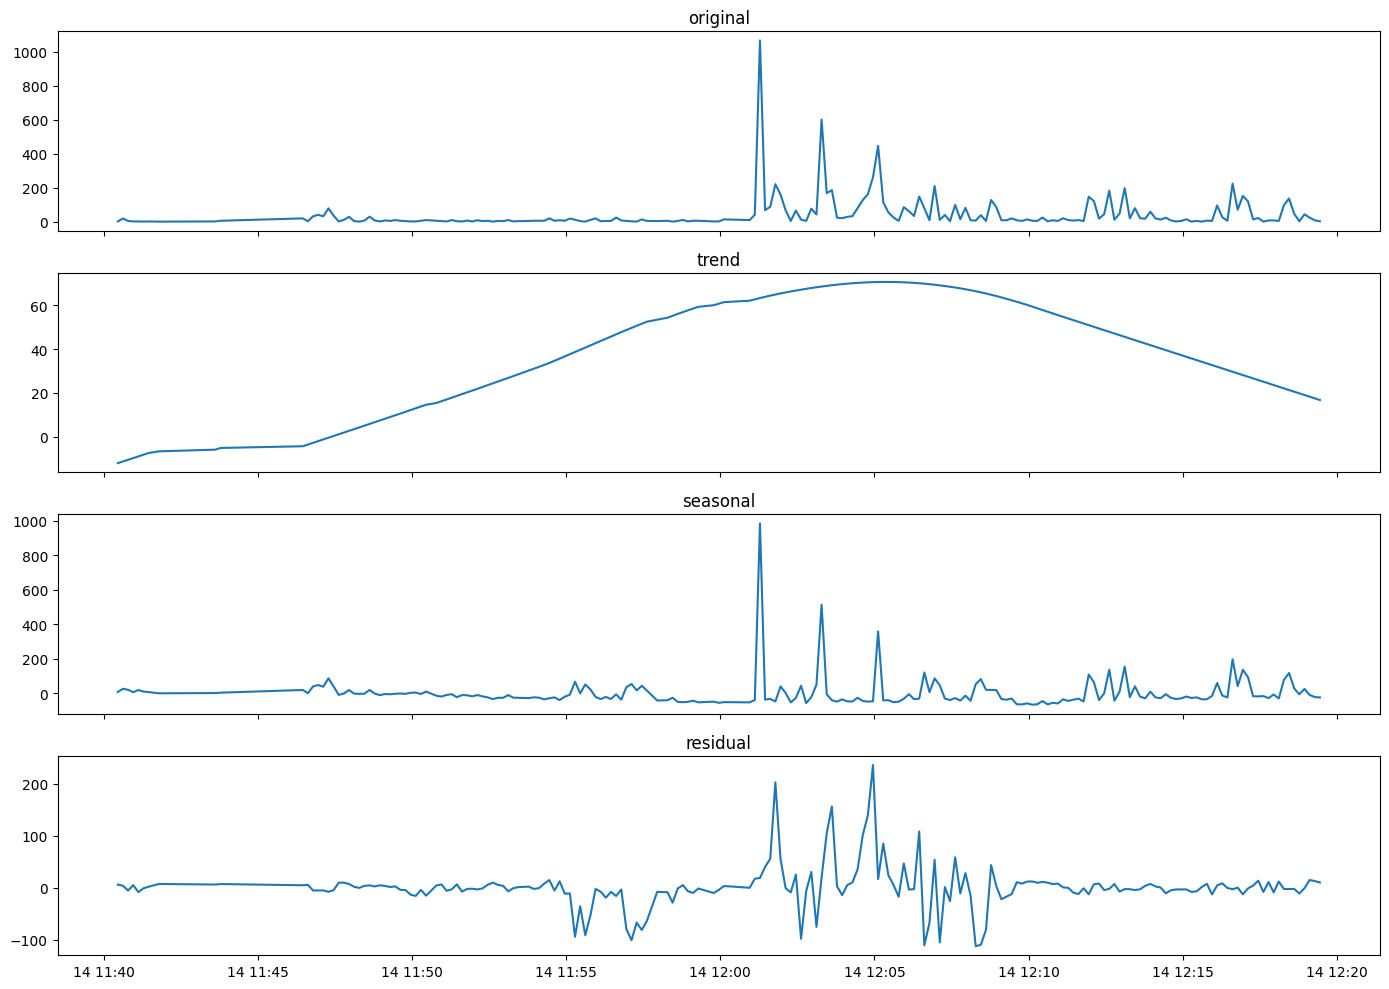


trend strength: 0.253
seasonal strength: 0.835


In [178]:
# Cell - STL decomposition

from statsmodels.tsa.seasonal import STL

# для STL нужен достаточно длинный ряд
if len(train_ts) >= 50:
    # period: сколько окон в "цикле" 
    # для сетевого трафика попробуем period = 60 (минута при window=1s)
    period = min(60, len(train_ts) // 3)
    period = max(2, period)
    
    print(f"STL period: {period} windows ({period * WINDOW_SIZE} seconds)")
    
    stl = STL(train_ts, period=period, robust=True).fit()
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    axes[0].plot(train_ts.index, train_ts.values)
    axes[0].set_title("original")
    
    axes[1].plot(stl.trend.index, stl.trend.values)
    axes[1].set_title("trend")
    
    axes[2].plot(stl.seasonal.index, stl.seasonal.values)
    axes[2].set_title("seasonal")
    
    axes[3].plot(stl.resid.index, stl.resid.values)
    axes[3].set_title("residual")
    
    plt.tight_layout()
    plt.show()
    
    # сила сезонности и тренда
    var_resid = np.var(stl.resid.dropna())
    var_seasonal = np.var(stl.seasonal)
    var_trend = np.var(stl.trend.dropna())
    
    strength_seasonal = max(0, 1 - var_resid / (var_seasonal + var_resid))
    strength_trend = max(0, 1 - var_resid / (var_trend + var_resid))
    
    print(f"\ntrend strength: {strength_trend:.3f}")
    print(f"seasonal strength: {strength_seasonal:.3f}")
else:
    print(f"train too short for STL: {len(train_ts)} < 50")

/tmp/ipykernel_18191/143596272.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_18191/143596272.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_18191/143596272.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_18191/143596272.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_1

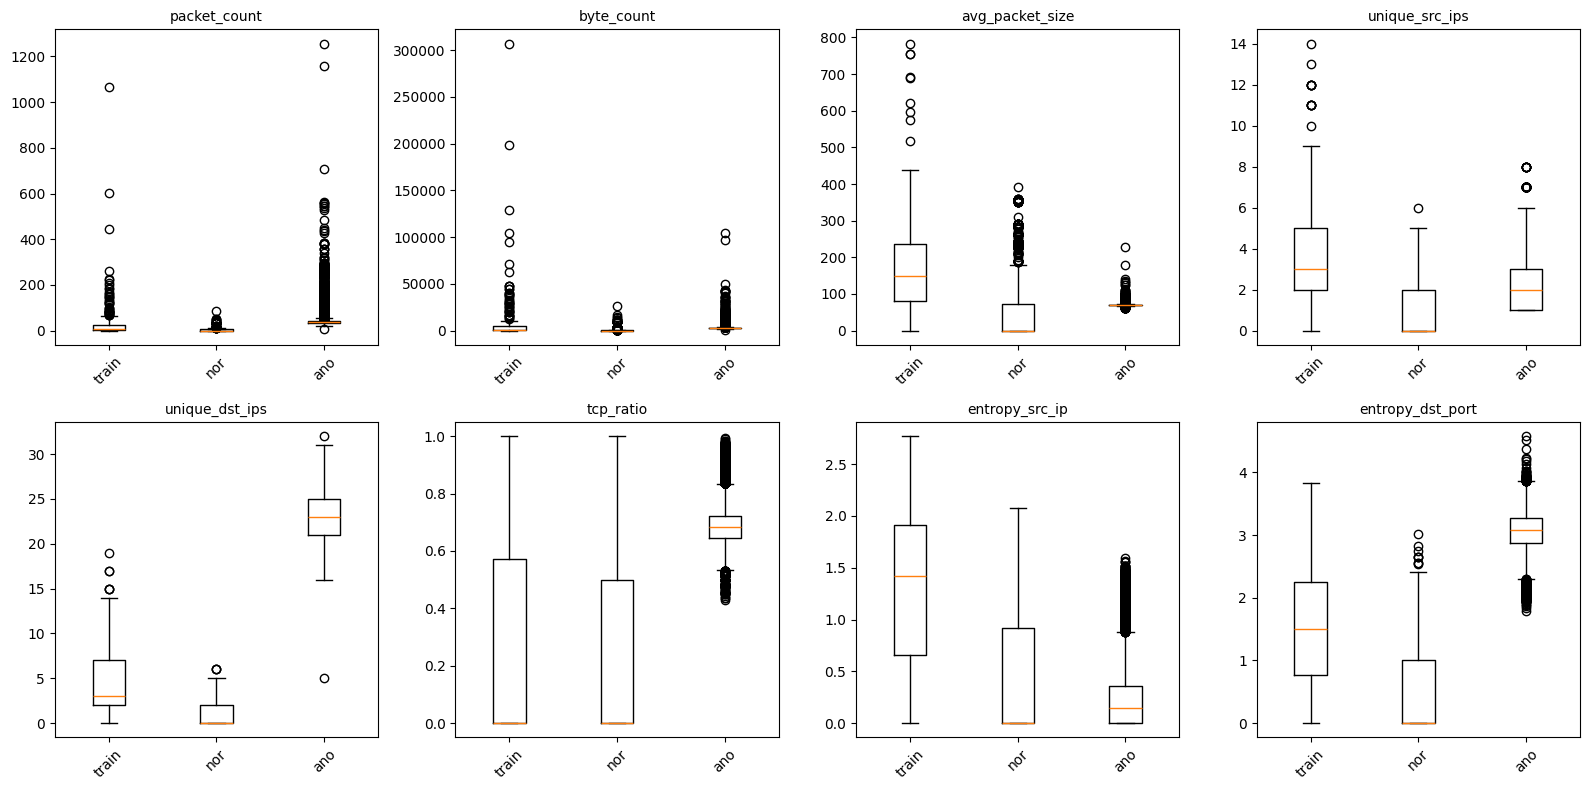

In [179]:
# Cell - Feature distributions

feature_cols = [c for c in train_df.columns if c not in {"timestamp", "label", "source"}]

# boxplots для сравнения train vs test
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

key_features = ["packet_count", "byte_count", "avg_packet_size", "unique_src_ips", 
                "unique_dst_ips", "tcp_ratio", "entropy_src_ip", "entropy_dst_port"]

for i, col in enumerate(key_features[:8]):
    if col not in train_df.columns:
        continue
    
    data = [train_df[col].values]
    labels = ["train"]
    
    for name, (df, label) in test_dfs.items():
        if col in df.columns:
            data.append(df[col].values)
            labels.append(f"{label[:3]}")
    
    axes[i].boxplot(data, labels=labels)
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

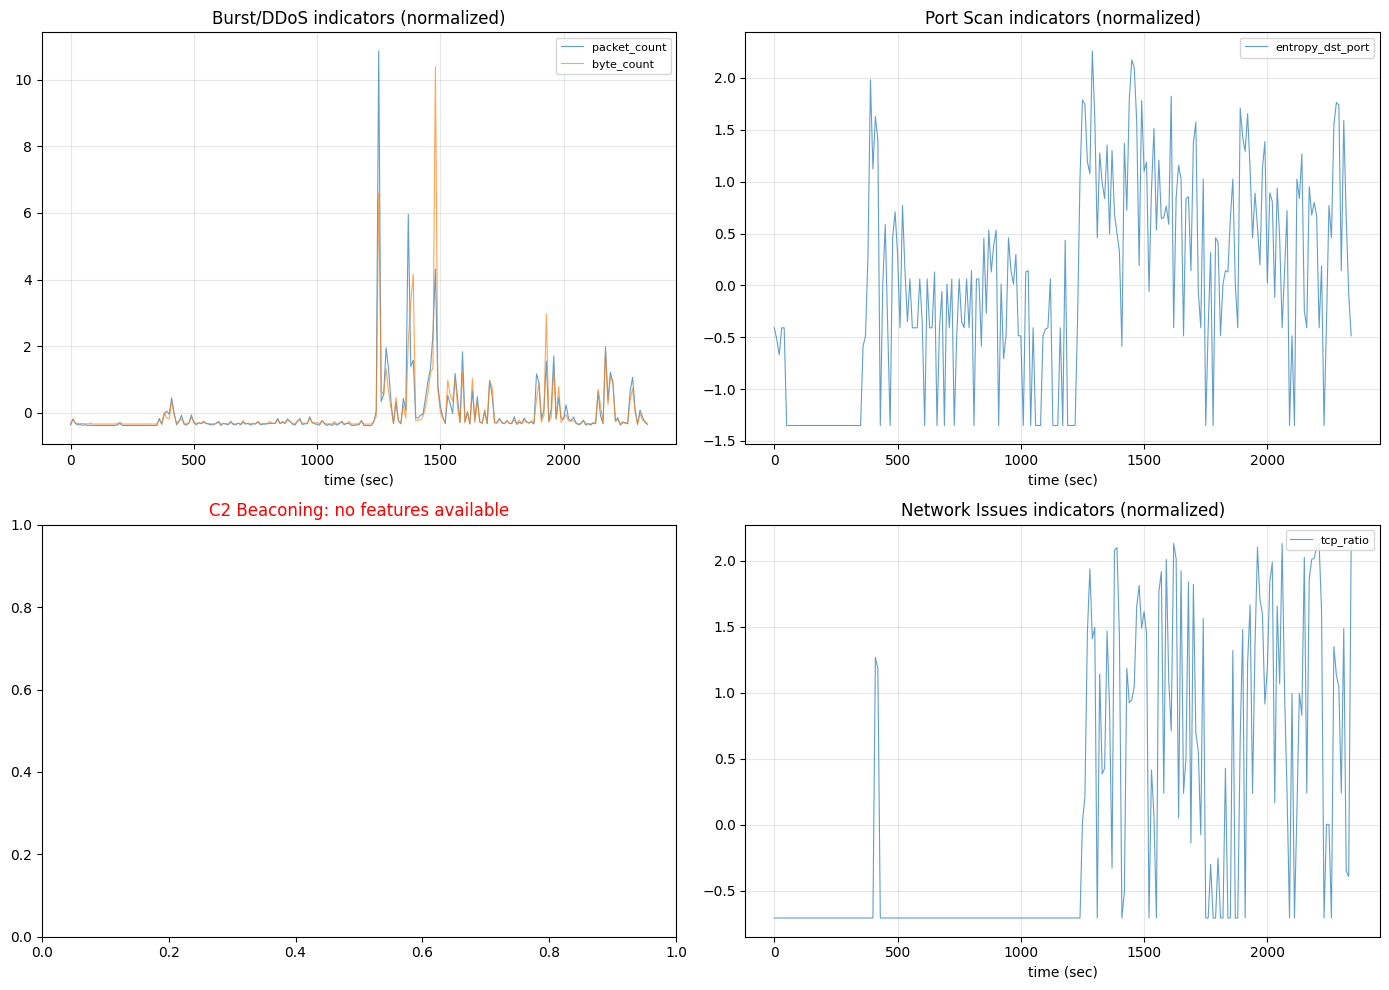

In [187]:
# Cell - Визуализация новых признаков для детекции (добавить в EDA секцию)

# Признаки важные для разных типов атак
attack_features = {
    "Burst/DDoS": ["packet_count", "byte_count", "packet_count_zscore"],
    "Port Scan": ["entropy_dst_port", "syn_only_count", "unique_flows"],
    "C2 Beaconing": ["iat_mean", "iat_cv"],
    "Network Issues": ["rst_ratio", "tcp_ratio"],
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (attack_type, features) in enumerate(attack_features.items()):
    ax = axes[idx]
    
    available_feats = [f for f in features if f in train_df.columns]
    if not available_feats:
        ax.set_title(f"{attack_type}: no features available", color="red")
        continue
    
    # Для каждого признака строим временной ряд
    for feat in available_feats:
        ts = train_df.set_index("timestamp")[feat].astype(float)
        time_sec = (ts.index - ts.index.min()).total_seconds()
        
        # Нормализуем для сравнения на одном графике
        ts_norm = (ts - ts.mean()) / (ts.std() + 1e-8)
        ax.plot(time_sec, ts_norm.values, alpha=0.7, label=feat, linewidth=0.8)
    
    ax.set_title(f"{attack_type} indicators (normalized)")
    ax.set_xlabel("time (sec)")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Общие утилиты для оценки и визуализации

In [180]:
# Cell - Общие утилиты для оценки и визуализации

def get_y_true(df: pd.DataFrame) -> np.ndarray:
    """все окна из файла с label='anomaly' считаются аномальными"""
    return (df["label"].str.lower() == "anomaly").to_numpy()


def evaluate(y_true: np.ndarray, y_pred: np.ndarray, name: str) -> dict:
    p, r, f1, _ = precision_recall_fscore_support(
        y_true.astype(int), y_pred.astype(int), average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true.astype(int), y_pred.astype(int))
    return {
        "model": name, 
        "precision": round(p, 4), 
        "recall": round(r, 4), 
        "f1": round(f1, 4),
        "confusion_matrix": cm,
    }


def plot_result(ts: pd.Series, pred: pd.Series, anomalies: np.ndarray, title: str,
                lower: pd.Series = None, upper: pd.Series = None):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    ax.plot(pred.index, pred.values, alpha=0.8, label="predicted")
    
    if lower is not None and upper is not None:
        ax.fill_between(pred.index, lower, upper, alpha=0.2, label="confidence")
    
    if anomalies.any():
        ax.scatter(ts.index[anomalies], ts.values[anomalies], c="red", s=20, zorder=5, label="anomaly")
    
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel(TARGET_COL)
    ax.legend()
    plt.tight_layout()
    plt.show()


# для текущего test файла
print(f"using test file: {test_name} ({test_label})")
print(f"test windows: {len(test_df)}, label distribution: {test_df['label'].value_counts().to_dict()}")

using test file: 2018-05-09-192.168.100.103 (anomaly)
test windows: 40286, label distribution: {'anomaly': 40286}


## ETS (Holt-Winters / Exponential Smoothing)

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/oppy/.cache/pypoetry/virtualenvs/hse-a

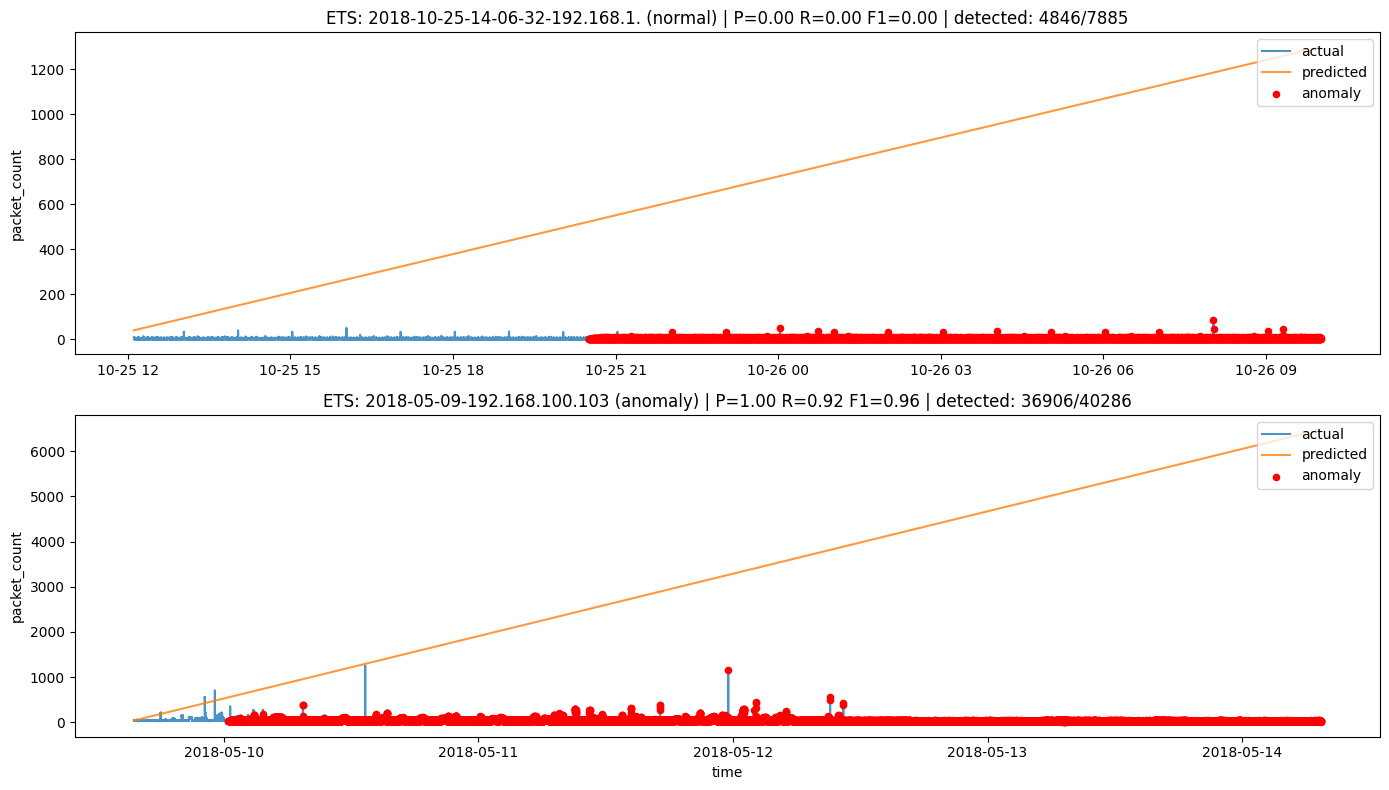


threshold: 522.84


/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


{'model': 'ets',
 'precision': 1.0,
 'recall': 0.9161,
 'f1': 0.9562,
 'confusion_matrix': array([[    0,     0],
        [ 3380, 36906]])}

In [181]:
# Cell - ETS (Holt-Winters / Exponential Smoothing)

from statsmodels.tsa.holtwinters import ExponentialSmoothing


def detect_with_ets(
    train: pd.Series,
    test: pd.Series,
    trend: str | None = "add",
    seasonal: str | None = None,
    seasonal_periods: int | None = None,
    q: float = 0.995,
) -> dict:
    model = ExponentialSmoothing(
        train,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
    ).fit(optimized=True)

    pred = model.forecast(len(test))
    pred.index = test.index

    train_fit = model.fittedvalues
    train_resid = (train - train_fit).dropna()
    thr = float(np.quantile(np.abs(train_resid.values), q))

    resid = (test - pred).values
    anomalies = np.abs(resid) > thr
    scores = np.maximum(np.abs(resid) - thr, 0.0)

    return {
        "pred": pred,
        "anomalies": anomalies,
        "scores": scores,
        "threshold": thr,
    }


fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (name, (df, label)) in enumerate(test_dfs.items()):
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    res = detect_with_ets(train_ts, ts, trend="add", seasonal=None, q=0.995)
    
    ax = axes[idx]
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    ax.plot(res["pred"].index, res["pred"].values, alpha=0.8, label="predicted")
    
    if res["anomalies"].any():
        ax.scatter(ts.index[res["anomalies"]], ts.values[res["anomalies"]], 
                   c="red", s=20, zorder=5, label="anomaly")
    
    report = evaluate(get_y_true(df), res["anomalies"], "ets")
    ax.set_title(f"ETS: {name[:30]} ({label}) | P={report['precision']:.2f} R={report['recall']:.2f} F1={report['f1']:.2f} | detected: {res['anomalies'].sum()}/{len(res['anomalies'])}")
    ax.set_ylabel(TARGET_COL)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Сохраняем репорт для anomaly файла
ets_res = detect_with_ets(train_ts, test_ts, trend="add", seasonal=None, q=0.995)
ets_report = evaluate(get_y_true(test_df), ets_res["anomalies"], "ets")
print(f"\nthreshold: {ets_res['threshold']:.2f}")
ets_report

## ARIMA

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-

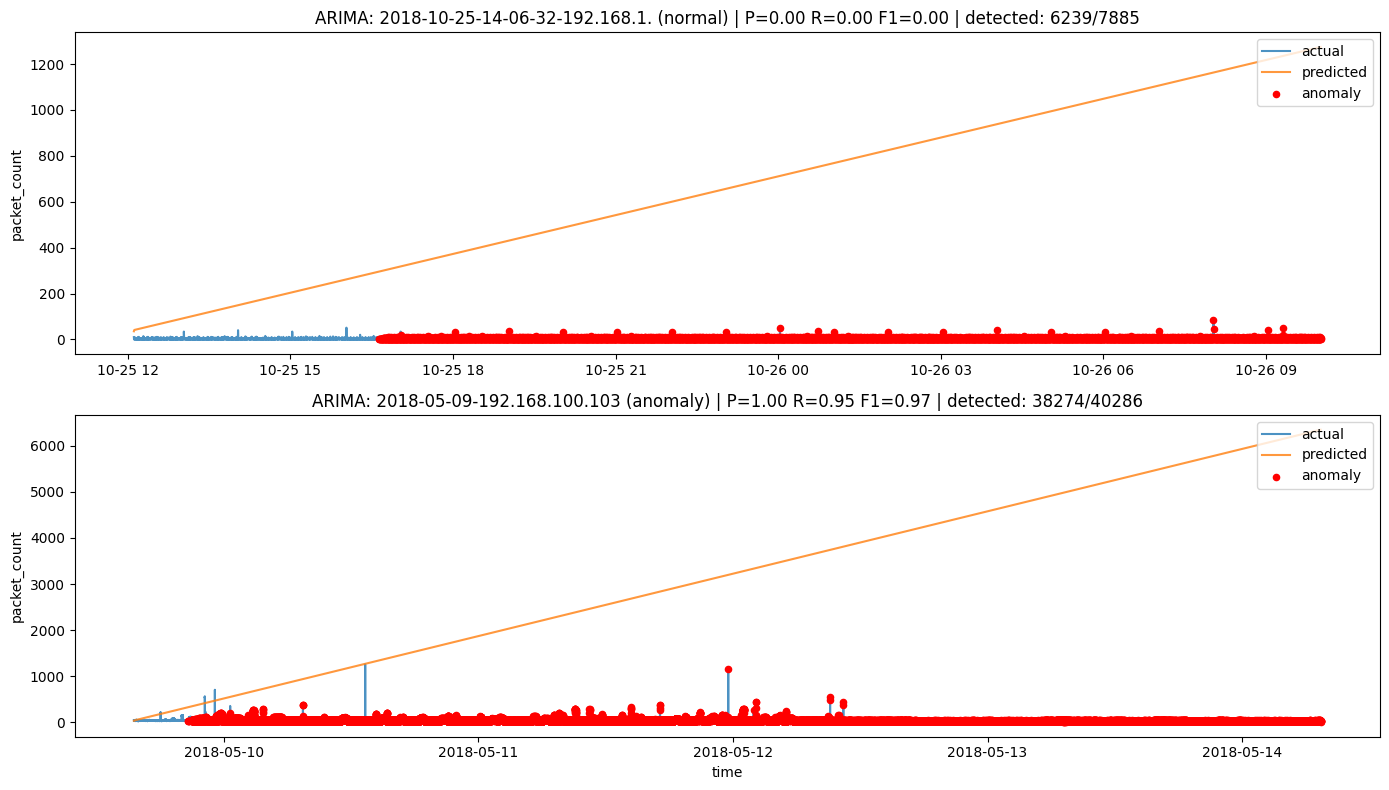

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-

{'model': 'arima',
 'precision': 1.0,
 'recall': 0.9501,
 'f1': 0.9744,
 'confusion_matrix': array([[    0,     0],
        [ 2012, 38274]])}

In [182]:
# Cell - ARIMA

detector = TimeSeriesAnomalyDetector()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (name, (df, label)) in enumerate(test_dfs.items()):
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    
    out = detector.detect_with_arima(
        train_data=train_ts,
        test_data=ts,
        order=(2, 1, 2),
        threshold=3.0,
    )
    
    ax = axes[idx]
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    ax.plot(out["predictions"].index, out["predictions"].values, alpha=0.8, label="predicted")
    
    if out["anomalies"].any():
        ax.scatter(ts.index[out["anomalies"]], ts.values[out["anomalies"]], 
                   c="red", s=20, zorder=5, label="anomaly")
    
    report = evaluate(get_y_true(df), out["anomalies"], "arima")
    ax.set_title(f"ARIMA: {name[:30]} ({label}) | P={report['precision']:.2f} R={report['recall']:.2f} F1={report['f1']:.2f} | detected: {out['anomalies'].sum()}/{len(out['anomalies'])}")
    ax.set_ylabel(TARGET_COL)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Сохраняем репорт для anomaly файла
arima_out = detector.detect_with_arima(train_data=train_ts, test_data=test_ts, order=(2, 1, 2), threshold=3.0)
arima_report = evaluate(get_y_true(test_df), arima_out["anomalies"], "arima")
arima_report

## SARIMA

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anoma

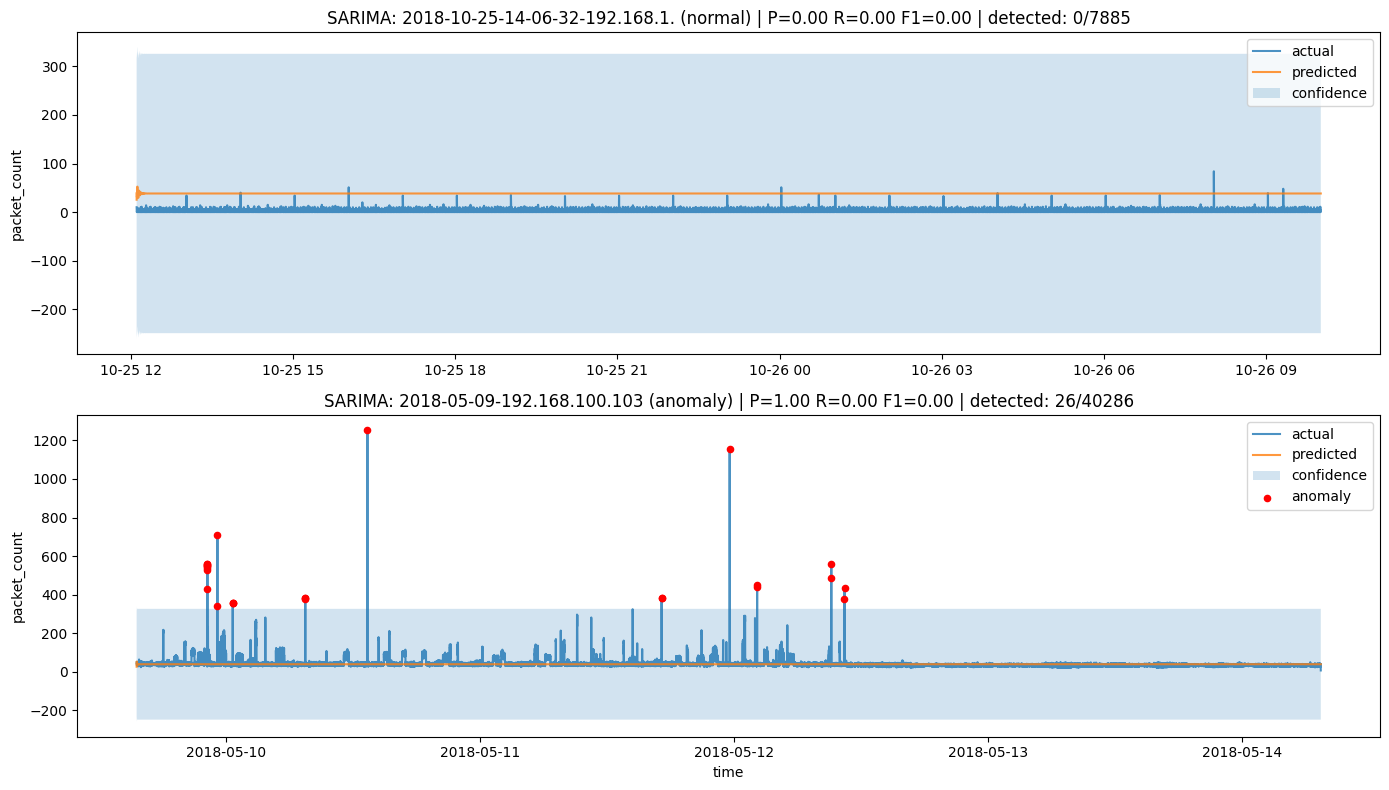

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anoma

{'model': 'sarima',
 'precision': 1.0,
 'recall': 0.0006,
 'f1': 0.0013,
 'confusion_matrix': array([[    0,     0],
        [40260,    26]])}

In [183]:
# Cell - SARIMA

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (name, (df, label)) in enumerate(test_dfs.items()):
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    
    out = detector.detect_with_sarima(
        train_data=train_ts,
        test_data=ts,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 6),
    )
    
    ax = axes[idx]
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    ax.plot(out["predictions"].index, out["predictions"].values, alpha=0.8, label="predicted")
    
    if out.get("lower_bound") is not None and out.get("upper_bound") is not None:
        ax.fill_between(out["predictions"].index, out["lower_bound"], out["upper_bound"], 
                        alpha=0.2, label="confidence")
    
    if out["anomalies"].any():
        ax.scatter(ts.index[out["anomalies"]], ts.values[out["anomalies"]], 
                   c="red", s=20, zorder=5, label="anomaly")
    
    report = evaluate(get_y_true(df), out["anomalies"], "sarima")
    ax.set_title(f"SARIMA: {name[:30]} ({label}) | P={report['precision']:.2f} R={report['recall']:.2f} F1={report['f1']:.2f} | detected: {out['anomalies'].sum()}/{len(out['anomalies'])}")
    ax.set_ylabel(TARGET_COL)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Сохраняем репорт для anomaly файла
sarima_out = detector.detect_with_sarima(train_data=train_ts, test_data=test_ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 6))
sarima_report = evaluate(get_y_true(test_df), sarima_out["anomalies"], "sarima")
sarima_report

## SARIMAX (экзогенные признаки)

Таргет: `packet_count`, экзогенные признаки: остальные оконные признаки.


exog features: ['byte_count', 'unique_src_ips', 'unique_dst_ips', 'tcp_ratio', 'entropy_dst_port']


/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10s will be used.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10s will be used.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodel

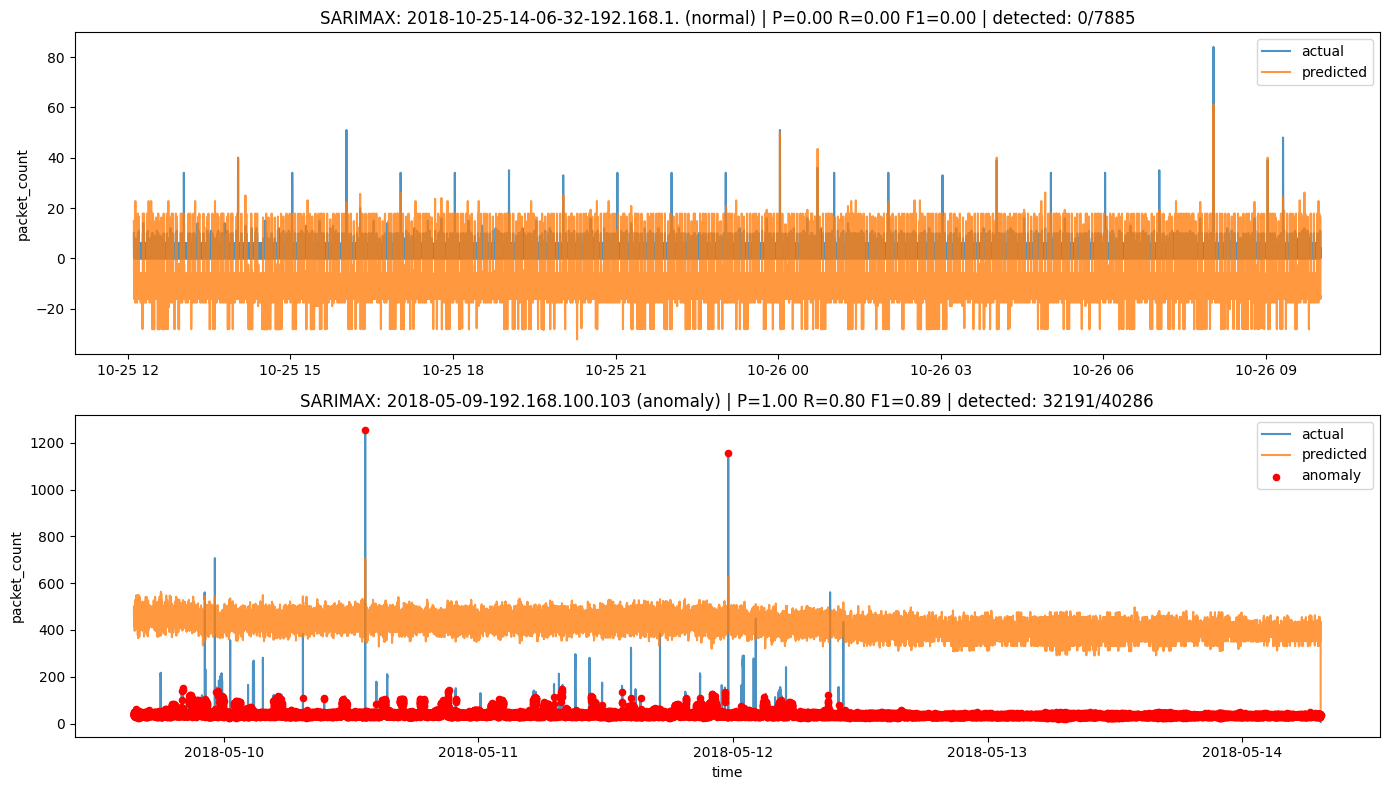

/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10s will be used.
  self._init_dates(dates, freq)
/home/oppy/.cache/pypoetry/virtualenvs/hse-ai-traffic-anomalies-Wb2nToOy-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10s will be used.
  self._init_dates(dates, freq)


threshold: 353.76


{'model': 'sarimax',
 'precision': 1.0,
 'recall': 0.7991,
 'f1': 0.8883,
 'confusion_matrix': array([[    0,     0],
        [ 8095, 32191]])}

In [184]:
# Cell - SARIMAX (экзогенные признаки)

from statsmodels.tsa.statespace.sarimax import SARIMAX


def detect_with_sarimax(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target: str,
    exog_cols: list[str],
    order: tuple[int, int, int] = (1, 1, 1),
    seasonal_order: tuple[int, int, int, int] = (0, 0, 0, 0),
    q: float = 0.995,
) -> dict:
    train = train_df.set_index("timestamp")
    test = test_df.set_index("timestamp")

    y_train = train[target].astype(float)
    y_test = test[target].astype(float)

    x_train = train[exog_cols].astype(float)
    x_test = test[exog_cols].astype(float)

    model = SARIMAX(
        endog=y_train,
        exog=x_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=len(y_test), exog=x_test)
    pred = fc.predicted_mean
    pred.index = y_test.index

    train_pred = fitted.get_prediction(exog=x_train).predicted_mean
    train_pred.index = y_train.index

    train_resid = (y_train - train_pred).dropna()
    thr = float(np.quantile(np.abs(train_resid.values), q))

    resid = (y_test - pred).values
    anomalies = np.abs(resid) > thr
    scores = np.maximum(np.abs(resid) - thr, 0.0)

    return {
        "pred": pred,
        "anomalies": anomalies,
        "scores": scores,
        "threshold": thr,
        "model": fitted,
    }


# выбираем только числовые признаки без производных
excluded = {"timestamp", "label", "source"}
base_features = ["byte_count", "unique_src_ips", "unique_dst_ips", "tcp_ratio", "entropy_dst_port"]
exog_cols = [c for c in base_features if c in train_df.columns]

print(f"exog features: {exog_cols}")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (name, (df, label)) in enumerate(test_dfs.items()):
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    
    res = detect_with_sarimax(
        train_df=train_df,
        test_df=df,
        target=TARGET_COL,
        exog_cols=exog_cols,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        q=0.995,
    )
    
    ax = axes[idx]
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    ax.plot(res["pred"].index, res["pred"].values, alpha=0.8, label="predicted")
    
    if res["anomalies"].any():
        ax.scatter(ts.index[res["anomalies"]], ts.values[res["anomalies"]], 
                   c="red", s=20, zorder=5, label="anomaly")
    
    report = evaluate(get_y_true(df), res["anomalies"], "sarimax")
    ax.set_title(f"SARIMAX: {name[:30]} ({label}) | P={report['precision']:.2f} R={report['recall']:.2f} F1={report['f1']:.2f} | detected: {res['anomalies'].sum()}/{len(res['anomalies'])}")
    ax.set_ylabel(TARGET_COL)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Сохраняем репорт для anomaly файла
sarimax_res = detect_with_sarimax(train_df=train_df, test_df=test_df, target=TARGET_COL, exog_cols=exog_cols, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), q=0.995)
sarimax_report = evaluate(get_y_true(test_df), sarimax_res["anomalies"], "sarimax")
print(f"threshold: {sarimax_res['threshold']:.2f}")
sarimax_report

## IsolationForest на оконных признаках

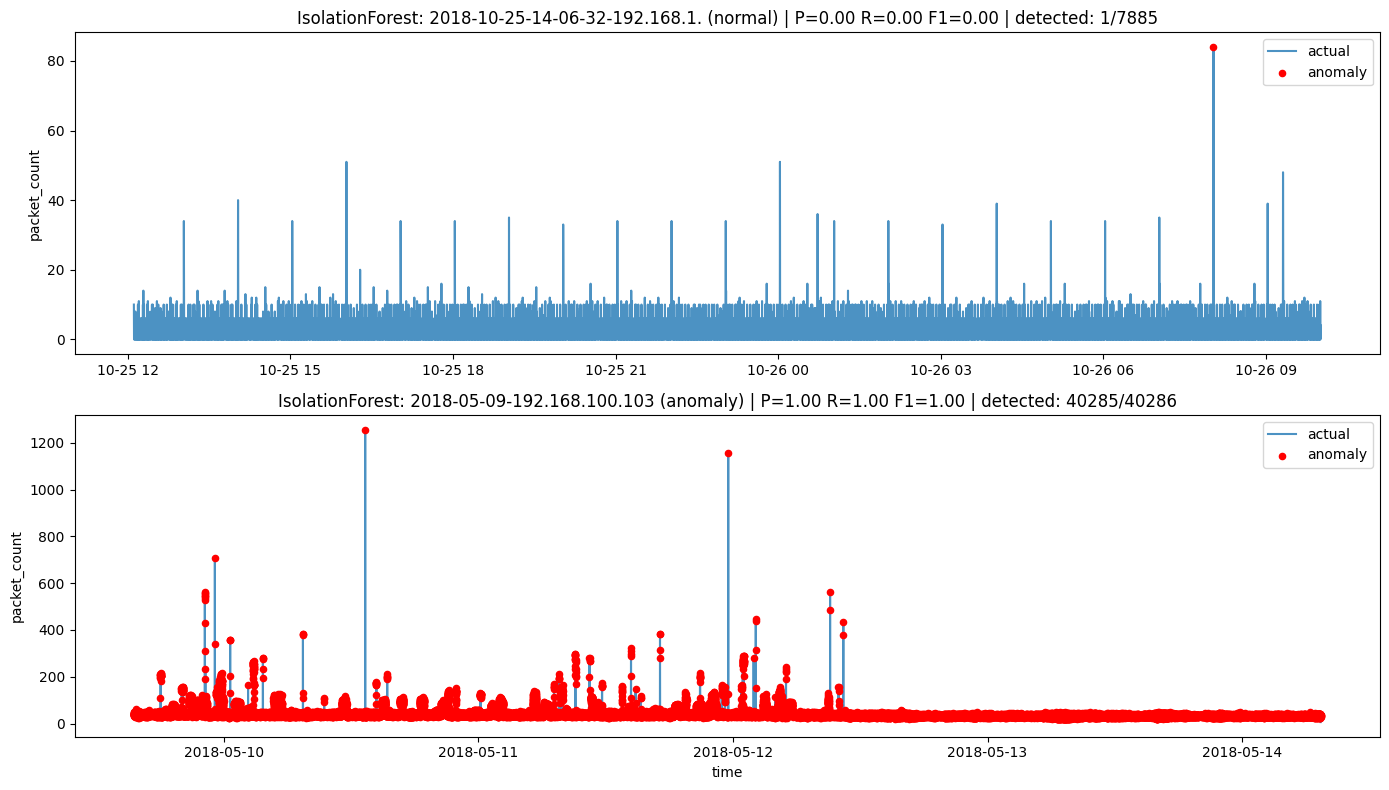

{'model': 'isolation_forest',
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'confusion_matrix': array([[    0,     0],
        [    1, 40285]])}

In [185]:
# Cell - IsolationForest на оконных признаках

feature_cols = [c for c in train_df.columns if c not in {"timestamp", "label", "source"}]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (name, (df, label)) in enumerate(test_dfs.items()):
    ts = df.set_index("timestamp")[TARGET_COL].astype(float)
    
    out = detector.detect_with_isolation_forest_ts(
        train_data=train_df,
        test_data=df,
        feature_cols=feature_cols,
        contamination=0.05,
    )
    
    ax = axes[idx]
    ax.plot(ts.index, ts.values, alpha=0.8, label="actual")
    
    if out["anomalies"].any():
        ax.scatter(ts.index[out["anomalies"]], ts.values[out["anomalies"]], 
                   c="red", s=20, zorder=5, label="anomaly")
    
    report = evaluate(get_y_true(df), out["anomalies"], "isolation_forest")
    ax.set_title(f"IsolationForest: {name[:30]} ({label}) | P={report['precision']:.2f} R={report['recall']:.2f} F1={report['f1']:.2f} | detected: {out['anomalies'].sum()}/{len(out['anomalies'])}")
    ax.set_ylabel(TARGET_COL)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()

# Сохраняем репорт для anomaly файла
iforest_out = detector.detect_with_isolation_forest_ts(train_data=train_df, test_data=test_df, feature_cols=feature_cols, contamination=0.05)
iforest_report = evaluate(get_y_true(test_df), iforest_out["anomalies"], "isolation_forest")
iforest_report

## Сводка метрик

In [186]:
# Cell - Сводка метрик

results_df = pd.DataFrame([
    ets_report, 
    arima_report, 
    sarima_report, 
    sarimax_report, 
    iforest_report
])

print("=== Сводка метрик ===\n")
display(results_df.drop(columns=["confusion_matrix"]).sort_values("f1", ascending=False))

# confusion matrices
print("\n=== Confusion Matrices ===")
for report in [ets_report, arima_report, sarima_report, sarimax_report, iforest_report]:
    print(f"\n{report['model']}:")
    print(report["confusion_matrix"])

=== Сводка метрик ===



,model,precision,recall,f1
4,isolation_forest,1.0,1.0000,1.0000
1,arima,1.0,0.9501,0.9744
0,ets,1.0,0.9161,0.9562
3,sarimax,1.0,0.7991,0.8883
2,sarima,1.0,0.0006,0.0013



=== Confusion Matrices ===

ets:
[[    0     0]
 [ 3380 36906]]

arima:
[[    0     0]
 [ 2012 38274]]

sarima:
[[    0     0]
 [40260    26]]

sarimax:
[[    0     0]
 [ 8095 32191]]

isolation_forest:
[[    0     0]
 [    1 40285]]


## Комментарии к качеству

- Для ETS/SARIMA критичен `seasonal_periods` (или `s` в seasonal_order). Его нужно подбирать под характер трафика и размер окна.
- Порог через квантиль train-остатков обычно стабильнее, чем `k * std`, потому что трафик часто имеет тяжелые хвосты.
- Если в одном PCAP есть смесь нормального и аномального трафика, метрики по window-level будут занижены, потому что все окна получают один label.
